# Whole Genome Sequencing 101

This notebook goes through the main step of a whole genome sequencing (WGS) project. It presents:

1. [**DNA Sequencing**](#part1) - obtain *reads* from DNA fragments.
2. [**Genome Assembly**](#part2) - put together a *genome* from reads.
    1. [**De Novo Assembly**](#part21) - assemble the genome from scratch
    2. [**Reference-Based Assembly**](#part22) - assemble the genome by comparing it against a reference genome
3. [**Genome Annotation**](#part3) - document the *functions* of the genome.

**Remember**, this notebook is not a complete WGS tutorial! It only presents the key steps of WGS to
demonstrate their algorithmic complexity. A real bioinformatics pipeline typically does not rely
purely on a Python script but rather executes standalone programs. To learn how to do full WGS
pipelines, please refer to:

- https://pmc.ncbi.nlm.nih.gov/articles/PMC10646344/ for *de novo* WGS (i. e. use that when
  studying an organism or strain with no reference genome)
- https://bmcmedgenomics.biomedcentral.com/articles/10.1186/s12920-023-01495-x for *reference-based*
  WSG (i.e. use that when you have a reference genome for your organism / strain)

In [364]:
# Run this line to ensure that your environment is properly configured.
from random import choice, randint, shuffle
import time
import numpy as np
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw

<a id='part1'></a>

## 1. DNA Sequencing

DNA sequencing consists in readings DNA fragments to obtain *reads*, which are sequences of letters
that indicate the base pairs that make up the fragments. There are three *generations* of DNA
sequencing technologies:

| Generation       | Time Frame      | Max Read Length    | Other Names                                |
| ---------------- | --------------- | ------------------ | ------------------------------------------ |
| First            | 1977 - present  | 800 to 1000        | Sanger sequencing  |
| Second           | Mid 2000s - present | 50 to 300      | Next-generation sequencing (NGS), Massive parallel sequencing |
| Third            | Late 2000s - present | 100 000       | Long-read sequencing |

DNA sequencing devices and processing software produce **sequencing files**. FASTQ is a format for
such files. For instance, the following cell is taken from the project described at
https://pmc.ncbi.nlm.nih.gov/articles/PMC9299564/. You can download the sequencing file from the
sequence read archive at https://www.ncbi.nlm.nih.gov/sra?term=SRR10256704.

```
@SRR10256704.1 1 length=137
ACGCGTGATCAGCAAAAGCAGGTCAAATATATTCAATATGGAGAGAATAAAAGAGCTGAGAGATCTAATGTCGCAGTCCCGCACTCGCGAGATACTCACTAAGACCACTGTGGACCATATGGCCATCATCAAAAAAT
+SRR10256704.1 1 length=137
?????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????
```

The fourth line (`???...`) indicates the **Phred quality score** of the corresponding nucleotides.
The character `?` corresponds to a score of 30, which means that each nucleotide has a probability
of around 0.001 to be incorrectly sequenced. So the quality is pretty good! You can read more about
the quality scores at  https://en.wikipedia.org/wiki/Phred_quality_score.

## What Program to Use

- FastQC (https://www.bioinformatics.babraham.ac.uk/projects/fastqc/) to visualize quality.
- Trimmomatic (http://www.usadellab.org/cms/?page=trimmomatic) to trim low-quality extremities.
- Trim Galore (https://www.bioinformatics.babraham.ac.uk/projects/trim_galore/) another trimmer.

## How to Obtain Sequences

- To **sequence** DNA, each sequencing device manufacturer releases their own software to process
  the data produced by the devices into sequencing files.
- To **download** DNA sequences that have already been sequenced, you can use:
  - The SRA Toolkit (https://github.com/ncbi/sra-tools/wiki) for sequences hosted by the NCBI (you
    can also visit https://www.ncbi.nlm.nih.gov/sra to download sequences from a browser)
  - The European Nucleotide Archive (https://www.ebi.ac.uk/ena/browser/home), another DNA data bank
    from the EMBL.
  - The DNA DataBank of Japan (DDBJ, https://www.ddbj.nig.ac.jp/index-e.html), another DNA data bank

Most journals require DNA sequences used for a research paper to be deposited in a DNA data bank,
so you can find a lot of sequences on the NCBI/EMBL/DDBJ portals!

<a id='part2'></a>

## 2. Genome Assembly

DNA sequencing technologies only sequence relatively short reads (maximum 100,000 with 3rd gen).
Human chromosomes are much longer than that - from ~47 million base pairs for chromosome 21 to ~249
million base pairs for chromosome 1 (https://www.ncbi.nlm.nih.gov/books/NBK22266/). Ok, the
mitochondrial chromosome is much smaller and *can* get read in one pass of a third generation
sequencer, but that's an exception. We have to split the chromosomes into shorter fragments,
sequence them separately, and assemble them. There are two main approaches to do that:

- De novo (i.e. assemble the fragments from scratch)
- Reference-based (i.e. align the fragments against a reference genome from a similar organism)

<a id='part21'></a>

## 2.1 De Novo Assembly

De novo assembly consists in stitching all reads together by finding their overlaps. Let's try a
naïve approach: each fragment will be compared to all other fragments.

For the sake of demonstration, let's generate a fake DNA sequence and simulate fragment reads:

In [320]:
NUCLEOTIDES = ('A', 'T', 'C', 'G')
SEQUENCE_SIZE = 80
READ_AVERAGE_SIZE = 25
READ_VARIANCE = 12
COVERAGE = 3
MINIMUM_OVERLAP = 4


sequence = "".join([choice(NUCLEOTIDES) for _ in range(SEQUENCE_SIZE)])
print("Simulated DNA sequence:")
print(sequence)
print()


def simulate_reads(sequence: str, variance: int, size: int, verbose: bool = True) -> list[str]:
    reads = []
    if verbose:
        print("Simulating fragment reads:")
    for _ in range(COVERAGE):
        offset = 0
        while offset < len(sequence):
            delta = size + randint(-variance, variance)
            endpoint = offset + delta
            if endpoint > len(sequence):
                endpoint = len(sequence)
            reads.append(sequence[offset:endpoint])
            if verbose:
                print(f"{' ' * offset}{reads[-1]}")
            offset += delta

    if verbose:
        print("Shuffling the reads!")
    shuffle(reads)
    if verbose:
        print(reads)
        print()
    return reads


reads = simulate_reads(sequence, READ_VARIANCE, READ_AVERAGE_SIZE)
print(f"We have {len(reads)} reads for a sequence of {SEQUENCE_SIZE} base pairs.")

Simulated DNA sequence:
TTACCTTCCGCGAAATTCAGCGGGACAGTTCGGCGCTTTGTCCCGTACGAAGTTCCCACACAAGACGCAAGTTGTGCATG

Simulating fragment reads:
TTACCTTCCGCGAAATTCAGCGGGACAGTT
                              CGGCGCTTTGTCCC
                                            GTACGAAGTTCCCACACAAGACGCAAGTTGT
                                                                           GCATG
TTACCTTCCGCGA
             AATTCAGCGGGACAGTTCGGCGCTTTGTCC
                                           CGTACGAAGTTCCCACA
                                                            CAAGACGCAAGTT
                                                                         GTGCATG
TTACCTTCCGCGAAATTCAGCGGGACAGTT
                              CGGCGCTTTGTCCCGTACGAAGTTCCC
                                                         ACACAAGACGCAAGTTGTGCATG
Shuffling the reads!
['GTACGAAGTTCCCACACAAGACGCAAGTTGT', 'TTACCTTCCGCGAAATTCAGCGGGACAGTT', 'GTGCATG', 'ACACAAGACGCAAGTTGTGCATG', 'TTACCTTCCGCGAAATTCAGCGGGACAGTT', 'CGGCGCTTTGTCCCGTACGAAGTTCC

Let's begin with a naïve approach that performs pairwise comparisons:

In [321]:
def naive_contig(reads: list[str], minimum_overlap: int) -> list[tuple]:
    """Elaborate contigs from the overlaps of the provided reads.

    E.g.:
        read:      AAAACCCC----
        candidate: ----CCCCTTTT
        overlap:       CCCC
        sequence:  AAAACCCCTTTT
    """
    contigs = []
    for i, read in enumerate(reads):
        for candidate in reads[i:]:
            if candidate == read:
                continue  # Do not compare a read to itself!
            overlap_scores = {}
            n_iterations = len(read) + len(candidate)
            for overlap_index in range(1, n_iterations):
                a = len(read) - overlap_index
                b = a + len(candidate)
                X = read[max(a, 0):min(b, len(read))]
                b = overlap_index
                a = overlap_index - len(read)
                Y = candidate[max(a, 0):min(b, len(candidate))]
                score = sum([1 if x == y else -1 for (x, y) in zip(X, Y)])
                overlap_scores[score] = overlap_index
            highest_overlap = max(overlap_scores)
            if highest_overlap >= minimum_overlap:
                offset = overlap_scores[highest_overlap]
                a = f"{'-' * (offset - len(read))}{read}{'-' * (len(candidate) - offset)}"
                b = f"{'-' * (len(read) - offset)}{candidate}{'-' * (offset - len(candidate))}"
                contig = []
                for x, y in zip(a, b):
                    contig.append(x if x != '-' else y)
                contig = "".join(contig)
                if len(contig) > len(read) and len(contig) > len(candidate):
                    contigs.append((read, candidate, offset, len(contig), contig, highest_overlap))
    return contigs


def assemble_with_naive_de_novo(reads: list, verbose: bool = True) -> str:
    current_contigs = reads
    overlap = 6
    for iteration in range(10):
        if verbose:
            print(f"Iteration {iteration}: {current_contigs}")
        initial_count = len(current_contigs)
        tentative = naive_contig(current_contigs, overlap)
        if not tentative:
            break
        contig_data = tentative
        current_contigs = [c[4] for c in contig_data]
        if len(current_contigs) > 32:
            current_contigs = current_contigs[:32]
        current_contigs = list(set(current_contigs))
        if len(current_contigs) in (1, initial_count):
            break
    return sorted(current_contigs, key = lambda x: len(x), reverse = True)[0]

In [322]:
assembly = assemble_with_naive_de_novo(reads)
print(f"Assembled sequence: {assembly}")
print(f"Original sequence:  {sequence}")

Iteration 0: ['GTACGAAGTTCCCACACAAGACGCAAGTTGT', 'TTACCTTCCGCGAAATTCAGCGGGACAGTT', 'GTGCATG', 'ACACAAGACGCAAGTTGTGCATG', 'TTACCTTCCGCGAAATTCAGCGGGACAGTT', 'CGGCGCTTTGTCCCGTACGAAGTTCCC', 'TTACCTTCCGCGA', 'CGTACGAAGTTCCCACA', 'CAAGACGCAAGTT', 'AATTCAGCGGGACAGTTCGGCGCTTTGTCC', 'GCATG', 'CGGCGCTTTGTCCC']
Iteration 1: ['GTACGAAGTTCCCACACAAGACGCAAGTTGTGCATG', 'AATTCAGCGGGACAGTTCGGCGCTTTGTCCCGTACGAAGTTCCC', 'AATTCAGCGGGACAGTTCGGCGCTTTGTCCC', 'CGTACGAAGTTCCCACACAAGACGCAAGTTGT', 'CGGCGCTTTGTCCCGTACGAAGTTCCCACA', 'CGGCGCTTTGTCCCGTACGAAGTTCCCACACAAGACGCAAGTTGT', 'TTACCTTCCGCGAAATTCAGCGGGACAGTTCGGCGCTTTGTCC']
Iteration 2: ['TTACCTTCCGCGAAATTCAGCGGGACAGTTCGGCGCTTTGTCCCGTACGAAGTTCCC', 'TTACCTTCCGCGAAATTCAGCGGGACAGTTCGGCGCTTTGTCCCGTACGAAGTTCCCACA', 'TTACCTTCCGCGAAATTCAGCGGGACAGTTCGGCGCTTTGTCCC', 'CGTACGAAGTTCCCACACAAGACGCAAGTTGTGCATG', 'AATTCAGCGGGACAGTTCGGCGCTTTGTCCCGTACGAAGTTCCCACA', 'CGGCGCTTTGTCCCGTACGAAGTTCCCACACAAGACGCAAGTTGT', 'CGGCGCTTTGTCCCGTACGAAGTTCCCACACAAGACGCAAGTTGTGCATG', 'TTACCTTCCGCG

It doesn't *always* converge to the right sequence because the reads are short and may overlap to
the wrong sequence, but this approach works most of the time. How fast is it?

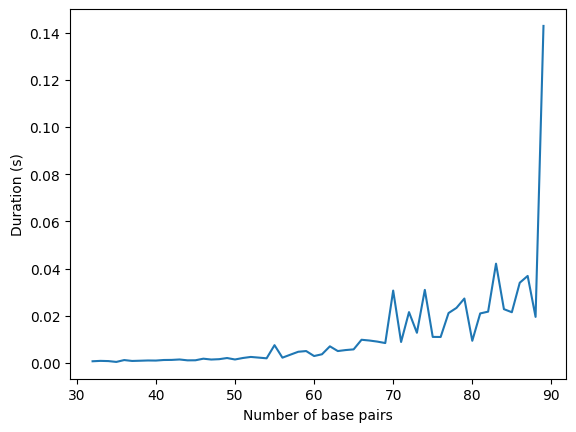

In [339]:
def benchmark_assembly(n: int) -> float:
    N = 10
    total = 0
    for _ in range(N):
        sequence = "".join([choice(NUCLEOTIDES) for _ in range(n)])
        reads = simulate_reads(sequence, READ_VARIANCE, READ_AVERAGE_SIZE, False)
        start = time.time()
        try:
            assemble_with_naive_de_novo(reads, False)
        except:
            print(f"Assembly with N = {n} failed.")
        end = time.time()
        total += end - start
    return total / N


fig, ax = plt.subplots()
N = range(32, 90)
durations = [benchmark_assembly(n) for n in N]
ax.plot(N, durations)
ax.set(xlabel='Number of base pairs', ylabel='Duration (s)')
plt.show()

😱 it runs in O(N<sup>2</sup>) time! That's no surprise, the number of comparisons increases
quadratically with the number of reads. If you wonder why the duration yoyos throughout the tests,
it's because, since the fragments are randomly split, they sometimes happen to be easier to
assemble.

Imagine assembling millions of reads like that! It's way too inefficient, so we'll see two
algorithms that can speed things up: overlap layout consensus (OLC) and De Bruijn graphs (DBG).
Check out https://ocw.mit.edu/courses/7-91j-foundations-of-computational-and-systems-biology-spring-2014/e885f0eb376ea6c2045eb9d8847f106f_MIT7_91JS14_Lecture6.pdf
for a more thorough discussion.

The OLC algorithm comprises three steps:

- Build an **overlap** graph (function `overlap_graph`)
- Reconstruct contigs from the graph - this is called **layout**
- Fix the errors and gaps by comparing the contigs - this is called **consensus** (not shown here)

In [324]:
def prune_unconnected_nodes(G: rx.PyDiGraph) -> None:
    to_remove = []
    for i in G.node_indices():
        if not G.in_edges(i) and not G.out_edges(i):
            to_remove.append(i)
    for r in to_remove:
        G.remove_node(r)


def overlap_graph(reads: list[str], minimum_overlap: int = 3) -> rx.PyDiGraph:
    graph = rx.PyDiGraph()
    nodes = []
    for read in reads:
        nodes.append(graph.add_node(read))
    for n in range(len(graph)):
        N = graph[n]
        for m in range(len(graph)):
            if n == m:
                continue
            M = graph[m]
            best = 0
            for overlap in range(minimum_overlap, len(N) + 1):
                N_suffix = N[-overlap:]
                M_prefix = M[:overlap]
                if N_suffix == M_prefix:
                    best = overlap
            if best:
                graph.add_edge(n, m, -best)
    prune_unconnected_nodes(graph)
    return graph


def find_sources(G: rx.PyDiGraph) -> list[int]:
    sources = []
    for i in G.node_indices():
        if not G.in_edges(i):
            sources.append(i)
    return sources


def find_sinks(G: rx.PyDiGraph) -> list[int]:
    sinks = []
    for i in G.node_indices():
        if not G.out_edges(i):
            sinks.append(i)
    return sinks


def overlap_layout_consensus_contig(reads: list[str], minimum_overlap: int) -> list[tuple]:
    """Elaborate contigs with OLC, which consists in constructing a graph
    directly from reads.
    """
    G = overlap_graph(reads, minimum_overlap)
    sources = find_sources(G)
    sinks = find_sinks(G)
    # Heuristic 1: Pick the longest source.
    source = sources[0]
    for s in sources[1:]:
        if len(G[s]) > len(G[source]):
            source = s
    # Heuristic 2: Find the shortest path through greedy search.
    path = [source]
    overlaps = [0]
    while True:
        try:
            edges = list(G.out_edges(path[-1]))
            edges = sorted(edges, key=lambda x: x[-1])
            edge = sorted(edges, key=lambda x: len(G[x[1]]), reverse=True)[0]
            path.append(edge[1])
            overlaps.append(edge[2])
        except:
            break
        if path[-1] in sinks:
            break
    # Reconstruct the sequence.
    sequence = ""
    for p, o in zip(path, overlaps):
        sequence += G[p][-o:]
    return sequence


def view_graph(G: rx.PyDiGraph, s: int = 12) -> None:
    figure, _ = plt.subplots()
    mpl_draw(
        G,
        with_labels=True,
        labels=str,
        edge_labels=str,
        node_color=[0.75, 0.75, 1],
        node_size=500
    )
    figure.set_figwidth(s)
    figure.set_figheight(s)
    plt.show()

Let's try it out with a simple example:

Original sequence: AAAACCCCTTTT
Overlap graph:


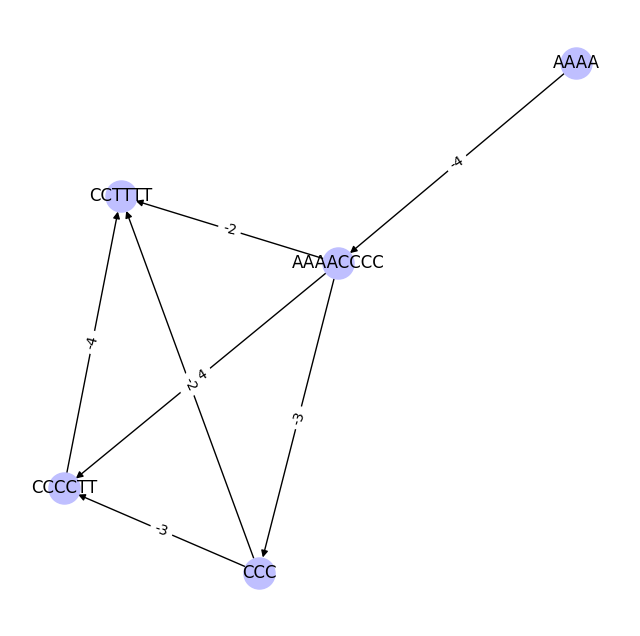

Layout assembly:   AAAACCCCTTTT


In [325]:
print("Original sequence: AAAACCCCTTTT")
reads = ("AAAACCCC", "CCCCTT", "CCTTTT", "AAAA", "CCC")
print("Overlap graph:")
G = overlap_graph(reads, 2)
view_graph(G, 8)
s = overlap_layout_consensus_contig(reads, 2)
print(f"Layout assembly:   {s}")

Ok, let's try with a simulated sequence:

In [ ]:
sequence = "".join([choice(NUCLEOTIDES) for _ in range(64)])
print(f"Original sequence: {sequence}")
reads = simulate_reads(sequence, 12, 24)
print("Reconstructing the sequence with OLC:")
s = overlap_layout_consensus_contig(reads, 6)
print(s)

Original sequence: AAAGGATCAACGTAGTGTGCCAATCAACCATGCAGGTAAAACCCCGGGGCGCGCCCTCTTTCTA
Simulating fragment reads:
AAAGGATCAACGTAGTGTGCCAATCAACCAT
                               GCAGGTAAAACCCCGGGGCGCGCCCTCTTTCTA
AAAGGATCAACGTAGTGTGCCAATCAA
                           CCATGCAGGTAAAACCCCGGGGCGCGCCC
                                                        TCTTTCTA
AAAGGATCAACGTA
              GTGTGCCAATCAACCATGCA
                                  GGTAAAACCCCGGGGCG
                                                   CGCCCTCTTTCTA
Shuffling the reads!
['CCATGCAGGTAAAACCCCGGGGCGCGCCC', 'GGTAAAACCCCGGGGCG', 'AAAGGATCAACGTAGTGTGCCAATCAACCAT', 'GCAGGTAAAACCCCGGGGCGCGCCCTCTTTCTA', 'AAAGGATCAACGTAGTGTGCCAATCAA', 'CGCCCTCTTTCTA', 'GTGTGCCAATCAACCATGCA', 'TCTTTCTA', 'AAAGGATCAACGTA']

Reconstructing the sequence with OLC:
AAAGGATCAACGTAGTGTGCCAATCAACCATGCAGGTAAAACCCCGGGGCGCGCCCTCTTTCTA


Pretty good! But it doesn't always converge because of the imperfect heuristics. Also, constructing
the graph is time-consuming. The function `overlap_graph` uses pairwise comparisons, so it takes
O(N<sup>2</sup>) time. It's possible to optimize it by binning the reads into categories based on
their prefix and suffix to avoid having to compute some alignments. Also, the layout (i.e.
reconstructing the sequence from the graph) is fast. So OLC is definitely an improvement over the
naïve approach, but it is most applicable to situations in which we have a few long reads, as with
third generation sequencing. In second generation sequencing, the reads are so numerous that
building the overlap graph is expensive.

An algorithm to assemble a very large number of reads is the De Bruijn graph. This method relies on
k-mers, the set of possible substrings that can be elaborated from a string. K-mers act like
specific markers in a sequence, and we will assemble the reads from these markers instead of the
full reads. This makes the computations faster, but it also makes the reconstruction of the original
sequence less accurate.

In [327]:
def get_k_mers(s: str, k: int) -> list[str]:
    """Generate the k-mers of a sequence `s`.

    E.g.:

    >>> get_k_mers("ACGTTCGT", 3)
    ["ACG", "CGT", "GTT", "TTG", "TCG"]
    """
    k_mers = []
    for i in range(len(s) - k + 1):
        k_mers.append(s[i:i + k])
    return list(set(k_mers))


def left_right_k_mers(s: str) -> tuple[str]:
    """Return the left and right (k-1)-mers of the input.

    E.g.:

    >>> left_right_k_mers("ACGT")
    ("ACG", "CGT")
    """
    return s[:-1], s[1:]


def de_bruijn_graph(reads: list[str], k: int) -> list[tuple]:
    """Create a De Bruijn graph."""
    graph = rx.PyDiGraph()
    kmers = []
    for read in reads:
        kmers += get_k_mers(read, k)
    nodes = {}
    for kmer in kmers:
        left_kmer, right_kmer = left_right_k_mers(kmer)
        # Add nodes
        if left_kmer not in nodes:
            nodes[left_kmer] = graph.add_node(left_kmer)
        if right_kmer not in nodes:
            nodes[right_kmer] = graph.add_node(right_kmer)
        # Create edges
        a, b = nodes[left_kmer], nodes[right_kmer]
        if not graph.edge_indices_from_endpoints(a, b) and a != b:
            graph.add_edge(a, b, 1)
    # Connect to another node.
    for node in nodes:
        for base in NUCLEOTIDES:
            target = node[1:] + base
            if target in nodes:
                a, b = nodes[node], nodes[target]
                if a == b:
                    continue
                edge_index = graph.edge_indices_from_endpoints(a, b)
                if not edge_index:
                    graph.add_edge(a, b, 1)
                else:
                    v = graph.get_edge_data(a, b)
                    graph.update_edge(a, b, v + 1)
    return graph


def de_bruijn_contig(reads: list[str], k: int) -> list[tuple]:
    G = de_bruijn_graph(reads, k)
    sources = find_sources(G)
    sinks = find_sinks(G)
    source = sources[0]
    # Find the shortest path through greedy search.
    path = [source]
    while True:
        try:
            edges = list(G.out_edges(path[-1]))
            edges = sorted(edges, key=lambda x: x[-1])
            edge = sorted(edges, key=lambda x: len(G[x[1]]), reverse=True)[0]
            path.append(edge[1])
        except:
            break
        if path[-1] in sinks:
            break
    # Reconstruct the sequence.
    sequence = ""
    for p in path:
        sequence += G[p][0]
    sequence += G[p][1:]
    return sequence

Original sequence: AAAACCCCTTTT
De Bruijn graph:


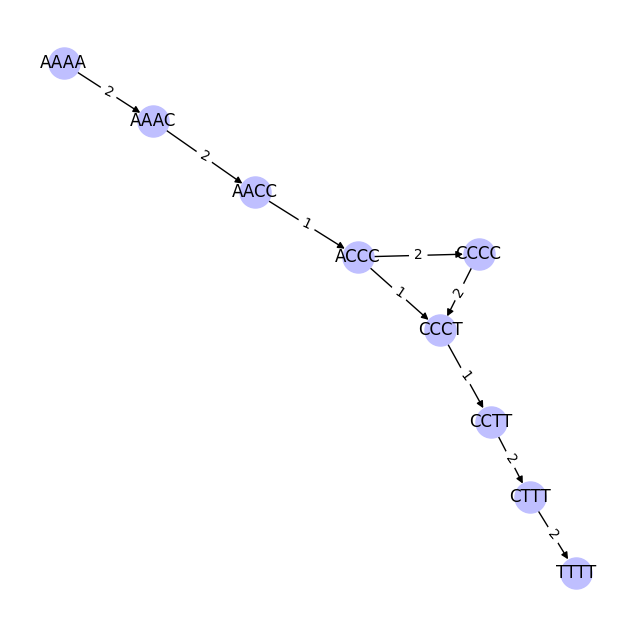

Layout assembly:   AAAACCCTTTT
Original sequence: AAAACCCCTTTT


In [329]:
print("Original sequence: AAAACCCCTTTT")
reads = ("ACCCCT", "CCTTTT", "AAAACC", "ACCCCT")
print("De Bruijn graph:")
G = de_bruijn_graph(reads, 5)
view_graph(G, 8)
reconstruction = de_bruijn_contig(reads, 5)
print(f"Layout assembly:   {reconstruction}")
print(f"Original sequence: AAAACCCCTTTT")

The bulge in the center of the graph is ambiguous. Using the greedy search heuristic, the `CCCC`
node is ignored, but it should actually be included to reconstruct the proper sequence. We can
mitigate this problem by using more advanced heuristics and longer K-mers, but the OLC method 
typically resolves such ambiguities and repetitions better than De Bruijn graphs. Let's try the DBG
with a simulated sequence:

In [335]:
sequence = "".join([choice(NUCLEOTIDES) for _ in range(64)])
print(f"Original sequence: {sequence}")
reads = simulate_reads(sequence, 12, 24)
print("Reconstructing the sequence with DBG:")
s = de_bruijn_contig(reads, 10)
print(s)

Original sequence: TCGCATAATCGTATCACAGCCAGAGGAGATAGAATGAGTCCTTAAACAGTAAAAAAAAAGCCGT
Simulating fragment reads:
TCGCATAATCGTATCACAGCCAGAGGA
                           GATAGAATGAGTCCTT
                                           AAACAGTAAAAAAAAAGCCGT
TCGCATAATCGT
            ATCACAGCCAGAGGAGATAGAATGAGT
                                       CCTTAAACAGTAAAAAAAAAGCC
                                                              GT
TCGCATAATCGTATCACAGCCAGAGGAGAT
                              AGAATGAGTCCTTA
                                            AACAGTAAAAAAAAAGCCGT
Shuffling the reads!
['TCGCATAATCGTATCACAGCCAGAGGAGAT', 'AACAGTAAAAAAAAAGCCGT', 'GT', 'CCTTAAACAGTAAAAAAAAAGCC', 'TCGCATAATCGT', 'GATAGAATGAGTCCTT', 'ATCACAGCCAGAGGAGATAGAATGAGT', 'AGAATGAGTCCTTA', 'AAACAGTAAAAAAAAAGCCGT', 'TCGCATAATCGTATCACAGCCAGAGGA']

Reconstructing the sequence with DBG:
TCGCATAATCGTATCACAGCCAGAGGAGATAGAATGAGTCCTTA


Given this simple heuristic, the lengths of the reads, and the chose K-mer length, the OLC method
generally outperforms the DBG in terms of accuracy, but the DBG is less computationally expensive.
So there's a tradeoff:

- OLC: Slow, precise. Good for assembling long reads.
- DBG: Fast, imprecise. Good for assembling short reads.

You can use the following programs for de novo assembly:

- **Overlap-layout-consensus** (primarily intended for 3rd generation sequencing):
  - Canu https://github.com/marbl/canu
  - Flye https://github.com/mikolmogorov/Flye
  - MECAT2 https://github.com/xiaochuanle/MECAT2
- **De Bruijn Graph**:
  - MEGAHIT https://github.com/voutcn/megahit
  - Velvet https://github.com/dzerbino/velvet
  - SPades https://github.com/ablab/ - can run in hybrid mode
- **Hybrid approach**:
  - MaSuRCA https://github.com/alekseyzimin/masurca
  - Unicycler https://github.com/rrwick/Unicycler

<a id='part22'></a>

## 2.2 Reference-Based Assembly

Reference-based assembly, also called mapping assembly, resequencing, or alignment in some contexts,
consists in matching the reads against a known reference genome. This only works if someone has
already sequenced a similar organism.

For instance, we already have a high quality reference genome for human beings
(GRCh38/hg38 https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000001405.40/), so when studying human
DNA, instead of stitching all the reads from a sequencer, we can just align them to this reference.
This is much faster than de novo assembly because is saves us a lot of pairwise comparisons. Of
course, all humans have a slightly different genome, but they are so similar that it's easy to align
them to the reference.

But a lot of organisms do not have a reference genome! This is especially problematic when studying
microbiomes, where thousands of species coexist and would each need to be aligned to specific
reference genomes that we don't even know in advance.

To demonstrate how reference-based assembly works, we'll simulate a reference genome and reads that
can align to it:

In [363]:
reference = "".join([choice(NUCLEOTIDES) for _ in range(100)])
print(f"Reference genome: {reference}")


def sample_read(reference: str, n: int, indel: int) -> tuple[str, int]:
    offset = randint(0, len(reference) - n)
    read = reference[offset:offset + n]
    modifications = (
        lambda s, x: s[:x] + choice(NUCLEOTIDES) + s[x:],  # Insertion
        lambda s, x: "".join([c for i, c in enumerate(s) if i != x])  # Deletion
    )
    for _ in range(indel):
        read = choice(modifications)(read, randint(0, len(read) - 1))
    return read, offset


read, offset = sample_read(reference, 16, 4)
print(f"            Read: {' ' * offset}{read}")

Reference genome: AGCAAATTAGCGACGCGGTCGCGGGGCCTCGTGCGCAGGCGCTTAAATCCCCGGACAGACTCGGCCTGTAGGTTGTGATGTTGAGAGGAGATAGTAGGCT
            Read:                           TCTGTGCGCAGGGC


As you can see, the simulated read does not exactly match the corresponding section in the reference
genome. That reflects how it works in real life: the differences between organisms and the errors of
the DNA sequencing devices entail discrepancies between the reads and the reference.

Let's try to align the simulated read back to the reference with the naïve approach: we'll use the
Smith-Waterman algorithm (https://en.wikipedia.org/wiki/Smith%E2%80%93Waterman_algorithm) to find
the best alignment between the reference and read.

In [392]:

def smith_waterman(ref, read, match_score=2, mismatch_penalty=-1, gap_penalty=-2) -> int:
    ref_len, read_len = len(ref), len(read)
    dp = np.zeros((read_len + 1, ref_len + 1))  # Dynamic programming matrix.
    max_score = 0
    best_pos = (0, 0)
    for i in range(1, read_len + 1):
        for j in range(1, ref_len + 1):
            match = dp[i - 1, j - 1] + (match_score if read[i - 1] == ref[j - 1] else mismatch_penalty)
            delete = dp[i - 1, j] + gap_penalty
            insert = dp[i, j - 1] + gap_penalty
            dp[i, j] = max(0, match, delete, insert)
            if dp[i, j] > max_score:
                max_score = dp[i, j]
                best_pos = (i, j)
    print(best_pos)
    return best_pos[1] - len(read)


print(f"Reference genome: {reference}")
read, offset = sample_read(reference, 16, 4)
alignment = smith_waterman(reference, read)
print(f"            Read: {' ' * offset}{read}")
print(f"       Alignment: {' ' * alignment}{read}")

Reference genome: AGCAAATTAGCGACGCGGTCGCGGGGCCTCGTGCGCAGGCGCTTAAATCCCCGGACAGACTCGGCCTGTAGGTTGTGATGTTGAGAGGAGATAGTAGGCT
(20, 25)
            Read:          GCGAGCGACGGTTCGTCGGG
       Alignment:      GCGAGCGACGGTTCGTCGGG


That works, but it's **terrible** for performances! We use an N by M table to compute the algorithm,
where N and M are the lengths of the reference genome and read, respectively.

<a id='part3'></a>

## 3. Genome Annotation